### Introduction

The goal of this notebook is to build from scratch a neural network for an image classficiation task.

This is to have a good grasp of deep learning concepts ..

## Plan

**1-** Prepare the dataset

**2-** Implementing the forward pass

**3-** Implementing the backwad pass

**4-** Evaluating the performance of the nn

**5-** Experiments with the nn parametres and how they affect the performances 

Some questions that we want to answer are : 

* Can we find some correlation between the variance in the dataset and the size of the neural network? 
* Is the bias part of the neurons important in the task?
* Does the activation function affects the value to be choosen for the learning rate

### 1-  Loading the dataset

In [12]:
import tensorflow as tf

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display the shape of the loaded data
print("Training data shape:", x_train.shape)  # (60000, 28, 28)
print("Training labels shape:", y_train.shape)  # (60000,)
print("Test data shape:", x_test.shape)  # (10000, 28, 28)
print("Test labels shape:", y_test.shape)  # (10000,)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


###  2-  Visualizing the dataset

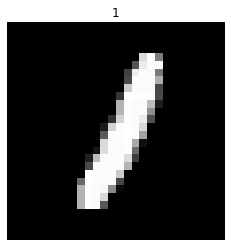

In [124]:
import matplotlib.pyplot as plt
import numpy as np

random_idx = np.random.randint(1000)

image = x_train[random_idx]
label = y_train[random_idx]
def visualizeImage(image,label):
    plt.imshow(image, cmap='gray')  # Display the image
    plt.axis('off')  # Turn off the axes
    plt.title(label)
    plt.show()  # Show the image
visualizeImage(image,label)


==> Each image is a **28*28** pixels, which gives a list of **784** elements

### 3- Implementing the forward pass

Our neural network, would be such that there is only one hidden layer with **300** neurons, and the output layer with **10**neurons

For now, the activations functions would be all linear, and in to generate the output we take the argmax.

Our loss function will be the Mean Squared Error, aka **MSE**

In [118]:
input_layer = image.flatten()

In [15]:
## Initializing the weights linking the input layer with the hidden layer

size_input_layer = len(input_layer) #784
size_hidden_layer = 300
size_output_layer = 10
print(len(input_layer))

weight_input_hidden = np.random.random((size_hidden_layer, size_input_layer))
weight_hidden_output = np.random.random((size_hidden_layer, size_output_layer))

784


In [16]:
# Hidden layer result
hidden_representation = np.dot(weight_input_hidden , input_layer)
hidden_representation.shape

(300,)

In [17]:
mi = hidden_representation.min()
ma = hidden_representation.max()

# min max normalization
norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

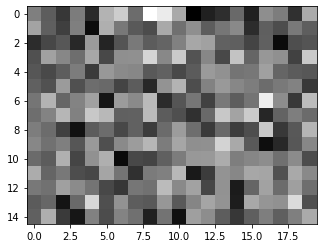

In [18]:
plt.imshow(norm_hidden_representation.reshape(15,20), cmap='gray')  # Display the image

In [19]:
## hidden output result 

ouput_result = np.dot(norm_hidden_representation, weight_hidden_output)
ouput_result.shape

(10,)

In [20]:
# Result of the forward pass
ouput_result.argmax()

7

In [21]:
# Defining the function that takes as an input the input layer(vector) and parameters and returns the predicted written number
def predictNumber(input_layer, weight_input_hidden, weight_hidden_output):
    size_input_layer = len(input_layer) #784
    size_hidden_layer = 300
    size_output_layer = 10

    hidden_representation = np.dot(weight_input_hidden , input_layer)
    mi = hidden_representation.min()
    ma = hidden_representation.max()

    # min max normalization
    norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

    ouput_result = np.dot(norm_hidden_representation, weight_hidden_output)
    # Result of the forward pass
    result = ouput_result.argmax()
    return result


In [25]:
# Defining the function that takes as an input the input layer(vector) and parameters and returns the predicted written number
def forward_pass(input_layer, weight_input_hidden, weight_hidden_output):
    size_input_layer = len(input_layer) #784
    size_hidden_layer = 300
    size_output_layer = 10

    hidden_representation = np.dot(weight_input_hidden , input_layer)
    mi = hidden_representation.min()
    ma = hidden_representation.max()

    # min max normalization
    norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

    output_result = np.dot(norm_hidden_representation, weight_hidden_output)
    
    return hidden_representation, output_result

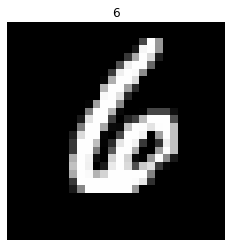

7

In [82]:
#Test
visualizeImage(image, label)
predictNumber(input_layer, weight_input_hidden, weight_hidden_output)

### 4- Implementing the backward pass:

This section would modify the *input_hidden_weights* and *hidden_output_weights* in order to make better predictions.

The weights modifications would be based on the backpropagation algorithms

In [83]:
def MSE(predicted, desired):
    # This function takes as input numpy arrays and not lists
    diff = 1/2 * ((predicted - desired)**2).sum()
    return diff

In [84]:
def backward_pass(weights, image, label, lr = 0.01):
    # We only modify the weights between the last and the penultimate layer
    
    size_hidden_layer = 300
    size_output_layer = 10
    
    # one hot encoding the label
    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1
    
    weight_input_hidden, weight_hidden_output = weights
    new_weight_input_hidden, new_weight_hidden_output = weight_input_hidden.copy(), weight_hidden_output.copy()
    
    input_layer = image.flatten()
    
    hidden_representation, output_result = forward_pass(input_layer, weight_input_hidden, weight_hidden_output)
    
    output_result =  tf.nn.softmax(output_result)
    
    for j in range(size_output_layer):
        for i in range(size_hidden_layer):
            delta = (output_result[j] - desired[j]) * hidden_representation[i]
            new_weight_hidden_output[i][j] = new_weight_hidden_output[i][j] - lr*delta 
            
    return new_weight_input_hidden, new_weight_hidden_output

In [125]:
# testing the backward pass 

# preparing the args

weights = weight_input_hidden, weight_hidden_output
image = x_train[random_idx]
label = y_train[random_idx]
desired = np.zeros(size_output_layer)
desired[int(label)] = 1

In [ ]:
_, new_weight_hidden_output = backward_pass(weights, image, label)

In [126]:
_, new_output = forward_pass(input_layer, weight_input_hidden, new_weight_hidden_output)
norm_new_output = np.array(tf.nn.softmax(new_output))
MSE(norm_new_output, desired)

1.0

In [127]:
_, old_output = forward_pass(input_layer, weight_input_hidden, weight_hidden_output)
norm_old_output = np.array(tf.nn.softmax(old_output))
MSE(old_output, desired)

28272.860107522432

In [128]:
new_output

array([ -441.5811049 ,   -81.76275619,    47.38852129,    49.20914712,
         -24.12427447,    68.92305455,    18.41411566,  7020.63267719,
        -841.98657187, -5062.57851898])